# Table of Contents
 <p>

In [2]:
from __future__ import division, print_function
from keras.layers import Input
from keras.layers.core import Activation, Dense, Dropout, Permute
from keras.layers.embeddings import Embedding
from keras.layers.merge import add, concatenate, dot
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import collections
import itertools
import nltk
import numpy as np
import matplotlib.pyplot as plt
import os

def get_data(infile):
    stories, questions, answers = [], [], []
    story_text = []
    fin = open(TRAIN_FILE, "rb")
    for line in fin:
        line = line.decode("utf-8").strip()
        lno, text = line.split(" ", 1)
        if "\t" in text:
            question, answer, _ = text.split("\t")
            stories.append(story_text)
            questions.append(question)
            answers.append(answer)
            story_text = []
        else:
            story_text.append(text)
    fin.close()
    return stories, questions, answers

def build_vocab(train_data, test_data):
    counter = collections.Counter()
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            for sent in story:
                for word in nltk.word_tokenize(sent):
                    counter[word.lower()] += 1
        for question in questions:
            for word in nltk.word_tokenize(question):
                counter[word.lower()] += 1
        for answer in answers:
            for word in nltk.word_tokenize(answer):
                counter[word.lower()] += 1
    # no OOV here because there are not too many words in dataset
    word2idx = {w:(i+1) for i, (w, _) in enumerate(counter.most_common())}
    word2idx["PAD"] = 0
    idx2word = {v:k for k, v in word2idx.items()}
    return word2idx, idx2word

def get_maxlens(train_data, test_data):
    story_maxlen, question_maxlen = 0, 0
    for stories, questions, _ in [train_data, test_data]:
        for story in stories:
            story_len = 0
            for sent in story:
                swords = nltk.word_tokenize(sent)
                story_len += len(swords)
            if story_len > story_maxlen:
                story_maxlen = story_len
        for question in questions:
            question_len = len(nltk.word_tokenize(question))
            if question_len > question_maxlen:
                question_maxlen = question_len
    return story_maxlen, question_maxlen

def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [[word2idx[w.lower()] for w in nltk.word_tokenize(s)] 
                                   for s in story]
        xs = list(itertools.chain.from_iterable(xs))
        xq = [word2idx[w.lower()] for w in nltk.word_tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer.lower()])
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           np_utils.to_categorical(Y, num_classes=len(word2idx))


#DATA_DIR = "../data"

#TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train.txt")
#TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test.txt")

# get the data
#data_train = get_data(TRAIN_FILE)
#data_test = get_data(TEST_FILE)

#print(len(data_train[0]), len(data_test[0]))

# build vocabulary from all the data
#word2idx, idx2word = build_vocab(data_train, data_test)

#vocab_size = len(word2idx)
#print("vocab size: {:d}".format(len(word2idx)))

# compute max sequence length for each entity
#story_maxlen, question_maxlen = get_maxlens(data_train, data_test)
#print("story maxlen: {:d}, question maxlen: {:d}".format(story_maxlen, question_maxlen))

# vectorize the data
#Xstrain, Xqtrain, Ytrain = vectorize(data_train, word2idx, story_maxlen, question_maxlen)
#Xstest, Xqtest, Ytest = vectorize(data_test, word2idx, story_maxlen, question_maxlen)

#print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

# define network
EMBEDDING_SIZE = 64
LATENT_SIZE = 32
BATCH_SIZE = 64
NUM_EPOCHS = 10
story_maxlen = 12
question_maxlen = 6
vocab_size = 2200

# inputs
story_input = Input(shape=(story_maxlen,))
question_input = Input(shape=(question_maxlen,))

# story encoder memory
story_encoder = Embedding(input_dim=vocab_size,
                         output_dim=EMBEDDING_SIZE,
                         input_length=story_maxlen)(story_input)
story_encoder = Dropout(0.3)(story_encoder)

# question encoder
question_encoder = Embedding(input_dim=vocab_size,
                            output_dim=EMBEDDING_SIZE,
                            input_length=question_maxlen)(question_input)
question_encoder = Dropout(0.3)(question_encoder)

# match between story and question
match = dot([story_encoder, question_encoder], axes=[2, 2])

# encode story into vector space of question
story_encoder_c = Embedding(input_dim=vocab_size,
                           output_dim=question_maxlen,
                           input_length=story_maxlen)(story_input)
story_encoder_c = Dropout(0.3)(story_encoder_c)

# combine match and story vectors
response = add([match, story_encoder_c])
response = Permute((2, 1))(response)

# combine response and question vectors
answer = concatenate([response, question_encoder], axis=-1)
answer = LSTM(LATENT_SIZE)(answer)
answer = Dropout(0.3)(answer)
answer = Dense(vocab_size)(answer)
output = Activation("softmax")(answer)

model = Model(inputs=[story_input, question_input], outputs=output)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy",
              metrics=["accuracy"])

# train model
#history = model.fit([Xstrain, Xqtrain], [Ytrain], batch_size=BATCH_SIZE, 
#                    epochs=NUM_EPOCHS,
#                    validation_data=([Xstest, Xqtest], [Ytest]))
                    
# plot accuracy and loss plot
#plt.subplot(211)
#plt.title("Accuracy")
#plt.plot(history.history["acc"], color="g", label="train")
#plt.plot(history.history["val_acc"], color="b", label="validation")
#plt.legend(loc="best")

#plt.subplot(212)
#plt.title("Loss")
#plt.plot(history.history["loss"], color="g", label="train")
#plt.plot(history.history["val_loss"], color="b", label="validation")
#plt.legend(loc="best")

#plt.tight_layout()
#plt.show()

# labels
#ytest = np.argmax(Ytest, axis=1)

# get predictions
#Ytest_ = model.predict([Xstest, Xqtest])
#ytest_ = np.argmax(Ytest_, axis=1)

#NUM_DISPLAY = 10

#for i in range(NUM_DISPLAY):
#    story = " ".join([idx2word[x] for x in Xstest[i].tolist() if x != 0])
#    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
#    label = idx2word[ytest[i]]
#    prediction = idx2word[ytest_[i]]
#    print(story, question, label, prediction)

In [3]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 12)            0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 6)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 12, 64)        140800      input_1[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 6, 64)         140800      input_2[0][0]                    
___________________________________________________________________________________________

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

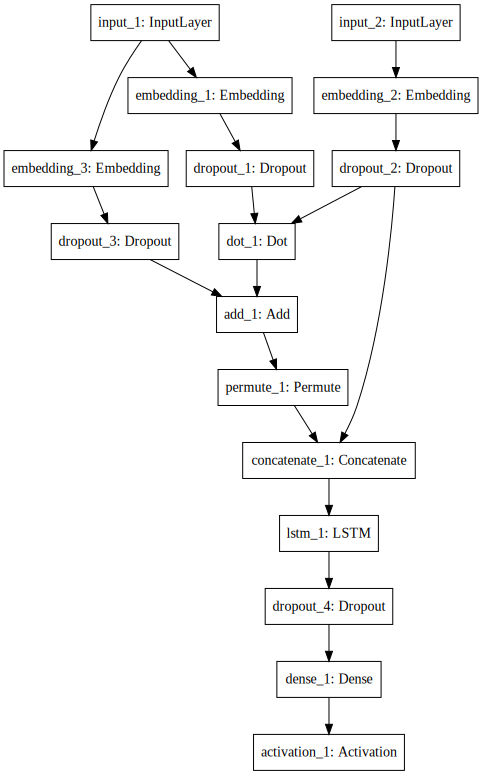

In [6]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))